In [33]:
import numpy as np
from scipy.stats import entropy
import torch
from cgan_code_5 import Generator  # 假设你有一个定义好的 Discriminator 类
import json
import random
import math
import struct
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [34]:
TOTAL_LEN = 114
# NPRINT_REAL_WIDTH = 50*8
NPRINT_REAL_WIDTH = 22*8
# LABEL_DICT = {'facebook': 0, 'skype': 1, 'aim': 2, 'email': 3, 'voipbuster': 4, 'hangouts': 5, 'youtube': 6, 'sftp': 7, 'icq': 8,  'ftps': 9, 'vimeo': 10, 'spotify': 11, 'netflix': 12, 'bittorrent': 13}
LABEL_DICT = {'facebook': 0, 'skype': 1}
# LABEL_DICT = {'facebook': 0, 'skype': 1, 'email': 2, 'voipbuster': 3, 'hangouts': 4, 'youtube': 5, 'ftps': 6, 'vimeo': 7, 'spotify': 8, 'netflix': 9, 'bittorrent': 10}
# LABEL_DICT = {'facebook': 0, 'skype': 1, 'email': 2, 'voipbuster': 3, 'youtube': 4, 'ftps': 5, 'vimeo': 6, 'spotify': 7, 'netflix': 8, 'bittorrent': 9}
# LABEL_DICT = {'email': 0, 'youtube': 1, 'ftps': 2, 'vimeo': 3, 'spotify': 4, 'netflix': 5, 'bittorrent': 6}

# SEQ_DIM = 3
MAX_PKT_LEN = 1500
MAX_TIME = 1000
MAX_PORT = 65536
MAX_SEQ_LEN = 16
WORD_VEC_SIZE = 8
SEQ_DIM = WORD_VEC_SIZE * 2 + 1

label_dim = len(LABEL_DICT) 
image_dim = (1, NPRINT_REAL_WIDTH, NPRINT_REAL_WIDTH)  # 生成单通道图像
noise_dim = 100  # 噪声维度
batch_size = 128
source_name = './data/vpn_data_small.json'
bins_name = './bins/bins_small.json'
model_name = './save_new/generator.pth'

In [35]:
bins_data = {}
with open(bins_name, 'r') as f_bin:
    bins_data = json.load(f_bin)
    
port_intervals = bins_data['port']['intervals']
pkt_len_intervals = []
for bins in bins_data['packet_len']:
    pkt_len_intervals.append(bins['intervals'])
time_intervals = []
for bins in bins_data['time']:
    time_intervals.append(bins['intervals'])

In [36]:
wv = {}
wv['time'] = Word2Vec.load("./wordvec/time.model")
wv['pkt_len'] = Word2Vec.load("./wordvec/pkt_len.model")

In [37]:
generator = Generator(label_dim, noise_dim, SEQ_DIM, MAX_SEQ_LEN, 'cpu')

# 加载模型权重
checkpoint = torch.load(model_name)  # 加载保存的权重字典
generator.load_state_dict(checkpoint)  # 将权重字典加载到模型中

# 切换到评估模式
generator.eval()

/tmp/ipykernel_1983852/3328781288.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_name)  # 加载保存的权重字典


Generator(
  (length_inputs): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (noise_inputs): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (tails): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (lstm): LSTM(512, 512, num_layers=4, batch_first=True)
  (output_layer): Sequential(
    (0): Linear(in_features=512, out_features=17, bias=True)
    (1): Tanh()
  )
)

In [38]:
checkpoint

OrderedDict([('length_inputs.0.0.weight',
              tensor([[-1.8488e-01, -1.0136e-01, -1.0580e-01,  ..., -4.6139e-02,
                       -1.6530e-01, -7.1448e-02],
                      [-1.1820e-02, -1.2895e-01,  1.4794e-01,  ..., -2.1884e-01,
                       -2.2884e-01,  3.8294e-01],
                      [ 1.8409e-01,  9.3931e-02,  1.8866e-01,  ...,  7.3744e-02,
                       -2.4655e-01, -2.4681e-02],
                      ...,
                      [ 8.3423e-02, -3.6679e-02,  2.4680e-01,  ...,  1.9063e-01,
                       -2.3670e-01,  3.3161e-01],
                      [ 1.9172e-02, -1.5762e-01, -4.3314e-02,  ...,  2.9689e-04,
                        3.9800e-01,  2.1128e-01],
                      [ 2.4189e-01,  3.4111e-02,  1.3944e-01,  ..., -8.8489e-02,
                       -6.0098e-02, -7.6545e-02]], device='cuda:0')),
             ('length_inputs.0.0.bias',
              tensor([ 0.2164, -0.0227,  0.0381,  0.1514, -0.0418,  0.0999,  0.0536, 

In [39]:
def group_by_length(data):
    grouped = {}
    for seq in data:
        length = len(seq)
        if length not in grouped:
            grouped[length] = []
        grouped[length].append(seq)
    return grouped

In [40]:
def js_divergence(p, q):
    p = np.array(p)
    q = np.array(q)
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

In [41]:
def compute_distribution(sequences):
    # 将所有序列合并为一个整体进行分布统计
    epsilon = 1e-9
    combined = np.vstack(sequences)  # 堆叠所有序列
    distribution = combined.mean(axis=0).flatten() + epsilon # 计算每个维度的均值
    distribution /= distribution.sum()  # 归一化为概率分布
    return distribution

In [42]:
def calculate_divergence(real_grouped, fake_grouped):
    total_divergence = 0
    total_count = 0

    for length in real_grouped.keys():
        if length not in fake_grouped:
            print(f"Warning: Length {length} is not in generated data.")
            continue

        real_sequences = real_grouped[length]
        fake_sequences = fake_grouped[length]

        # 计算真实数据分布和生成数据分布
        real_distribution = compute_distribution(real_sequences)
        fake_distribution = compute_distribution(fake_sequences)
        print(real_distribution)
        print()
        print(fake_distribution)

        # 计算 JS 散度
        divergence = js_divergence(real_distribution, fake_distribution)
        # print(f"Length {length}: JS Divergence = {divergence}")

        # 加权累加，权重为该类别的真实数据数量
        total_divergence += divergence * len(real_sequences)
        total_count += len(real_sequences)

    # 平均散度
    overall_divergence = total_divergence / total_count if total_count > 0 else 0
    return overall_divergence

In [43]:
def get_real_data(file_name):
    with open(file_name,'r') as f:
        json_data = json.load(f)['data']
    data_dic = {}
    
    for item in json_data:
        label_str = item['labels'][0]
        if label_str not in data_dic:
            data_dic[label_str] = []

        packets_len = item['meta']['packets']
        im = bytes.fromhex(item['nprint'])

        line = im[0:TOTAL_LEN]
        tcp_dport = line[32:34]
        udp_dport = line[92:94]

        dport = bytearray(a | b for a, b in zip(tcp_dport, udp_dport))
        dport = int.from_bytes(dport, 'big')
    
        data_item = []
        for i in range(min(16,packets_len)):
            line = im[i*TOTAL_LEN:i*TOTAL_LEN+TOTAL_LEN]
            time_h, time_l, pl = struct.unpack("IIh", line[:10])
            time_l //= 1e4
            time = time_h + time_l/100
            
            data_item.append([time, pl, dport])
            
        data_dic[label_str].append(data_item)
        
    return data_dic


In [44]:
real_datas = get_real_data(source_name)
print(real_datas)

{'facebook': [[[0.0, 1182, 443], [0.0, 1127, 443], [0.0, 613, 443], [0.1, 1264, 443], [0.0, 286, 443], [0.03, -52, 443], [0.0, -97, 443], [0.0, 52, 443], [0.07, -1390, 443], [0.0, 52, 443], [0.0, -481, 443], [0.0, 52, 443], [0.0, -172, 443], [0.0, 52, 443], [0.0, -99, 443], [0.0, 52, 443]], [[0.0, 62, 53], [0.0, -169, 53]], [[0.0, 62, 53], [0.0, -169, 53]], [[0.0, 62, 53], [0.07, -169, 53]], [[0.0, 62, 53], [0.0, -169, 53]], [[0.0, 69, 53], [0.09, -477, 53]], [[0.0, 594, 443], [0.0, 594, 443], [0.0, 594, 443], [0.01, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443]], [[0.0, 616, 443], [0.03, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0, 52, 443], [0.0, -1390, 443], [0.0,

In [45]:
class SequenceDataset(Dataset):
    def __init__(self, datas, label_str):
        """
        :param sequences: 一个包含真实序列的列表，每个序列是一个 ndarray 或 list
        """
        self.datas = datas
        self.lengths = [len(seq) for seq in datas]  # 提取序列长度
        label_id = LABEL_DICT[label_str]
        self.label_one_hot = torch.zeros(label_dim).to('cpu') 
        self.label_one_hot[label_id] = 1

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, idx):
        return self.lengths[idx],self.label_one_hot 

In [46]:
def get_fake_data(real_data, label_str):
    dataset = SequenceDataset(real_data,label_str)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
    generated_sequences = []
    with torch.no_grad():
        for lengths, labels in dataloader:
            lengths = lengths.to(torch.device("cpu"))  # 确保在同一个设备上
            labels = labels.to(torch.device("cpu"))
            # 生成随机噪声向量
            noise = torch.randn(len(lengths), noise_dim)
            # 输入生成器生成数据
            fake_data = generator(labels, noise, lengths)
            # 将生成结果按序列长度截断
            for i, length in enumerate(lengths):
                generated_sequences.append(fake_data[i, :length].cpu().tolist())
       
    final_seqs = []         
    for seq in generated_sequences:
        f_seq = []
        for i in range(len(seq)):
            [time,pkt_len,dport] = seq[i]       
            time_id = math.floor((time + 1)/2*len(time_intervals[i]))
            pkt_len_id = math.floor((pkt_len + 1)/2*len(pkt_len_intervals[i]))
            dport_id = math.floor((dport + 1)/2*len(port_intervals))
        
            time = round(random.uniform(time_intervals[i][time_id][0], time_intervals[i][time_id][1]),2)
            pkt_len = round(random.uniform(pkt_len_intervals[i][pkt_len_id][0], pkt_len_intervals[i][pkt_len_id][1]))
            dport = round(random.uniform(port_intervals[dport_id][0],port_intervals[dport_id][1]))
            f_seq.append([time,pkt_len,dport])
        final_seqs.append(f_seq)
    return final_seqs

In [47]:
def get_fake_data_wv(real_data, label_str, wordvec):
    dataset = SequenceDataset(real_data,label_str)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
    generated_sequences = []
    with torch.no_grad():
        for lengths, labels in dataloader:
            lengths = lengths.to(torch.device("cpu"))  # 确保在同一个设备上
            labels = labels.to(torch.device("cpu"))
            # 生成随机噪声向量
            noise = torch.randn(len(lengths), noise_dim)
            # 输入生成器生成数据
            fake_data = generator(labels, noise, lengths)
            # 将生成结果按序列长度截断
            for i, length in enumerate(lengths):
                generated_sequences.append(fake_data[i, :length].cpu().tolist())
       
    final_seqs = []         
    for seq in generated_sequences:
        f_seq = []
        for i in range(len(seq)):
            time_wv = np.array(seq[i][0:WORD_VEC_SIZE])
            pkt_len_wv = np.array(seq[i][WORD_VEC_SIZE:WORD_VEC_SIZE*2])
            dport = seq[i][WORD_VEC_SIZE*2]
            # [time,pkt_len,dport] = seq[i]       
            # time_id = math.floor((time + 1)/2*len(time_intervals[i]))
            # pkt_len_id = math.floor((pkt_len + 1)/2*len(pkt_len_intervals[i]))
            
            
            
            dport_id = math.floor((dport + 1)/2*len(port_intervals))
        
            # time = round(random.uniform(time_intervals[i][time_id][0], time_intervals[i][time_id][1]),2)
            # pkt_len = round(random.uniform(pkt_len_intervals[i][pkt_len_id][0], pkt_len_intervals[i][pkt_len_id][1]))
            # print(time_wv)
            # print(pkt_len_wv)
            
            time = int(wordvec['time'].wv.similar_by_vector(time_wv, topn=1)[0][0])
            pkt_len = int(wordvec['pkt_len'].wv.similar_by_vector(pkt_len_wv, topn=1)[0][0])
            dport = round(random.uniform(port_intervals[dport_id][0],port_intervals[dport_id][1]))
            f_seq.append([time,pkt_len,dport])
        final_seqs.append(f_seq)
    return final_seqs

In [48]:
fake_datas = {}
for label, data in real_datas.items():
    fake_data = get_fake_data_wv(data,label,wv)
    # fake_data = get_fake_data(data,label)
    fake_datas[label] = fake_data
    # for i in range(1):
    #     fake_data = get_fake_data(data,label)
    #     fake_datas[label] += fake_data
    # print(label)
    # print(data)
    # print(fake_data)
    # real_grouped = group_by_length(data)
    # fake_grouped = group_by_length(fake_data)
    # overall_js_divergence = calculate_divergence(real_grouped, fake_grouped)
    # print(f"Overall JS Divergence {label}: {overall_js_divergence}")
    

In [49]:
def pad(sequence, target_length, pad_value=np.nan):
    seq_len = len(sequence)
    if seq_len < target_length:
        padding = [[pad_value] * len(sequence[0])] * (target_length - seq_len)
        return sequence + padding  # 填充
    return sequence

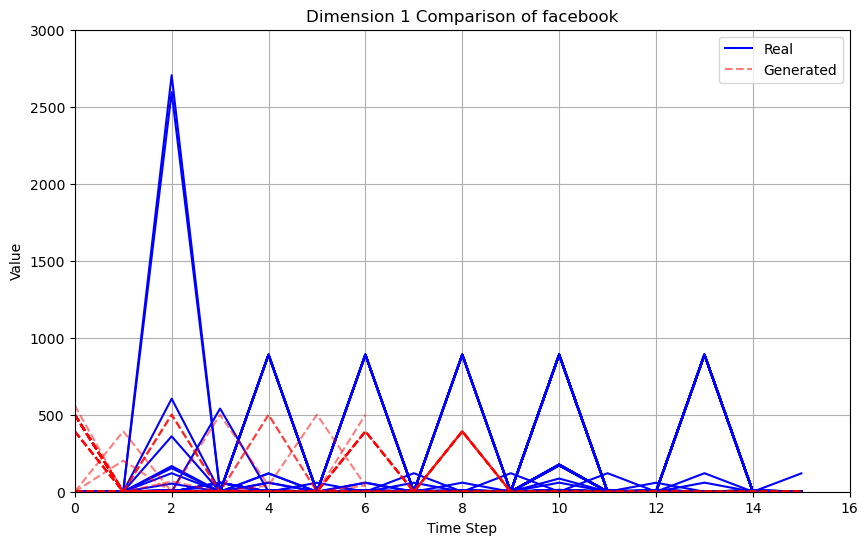

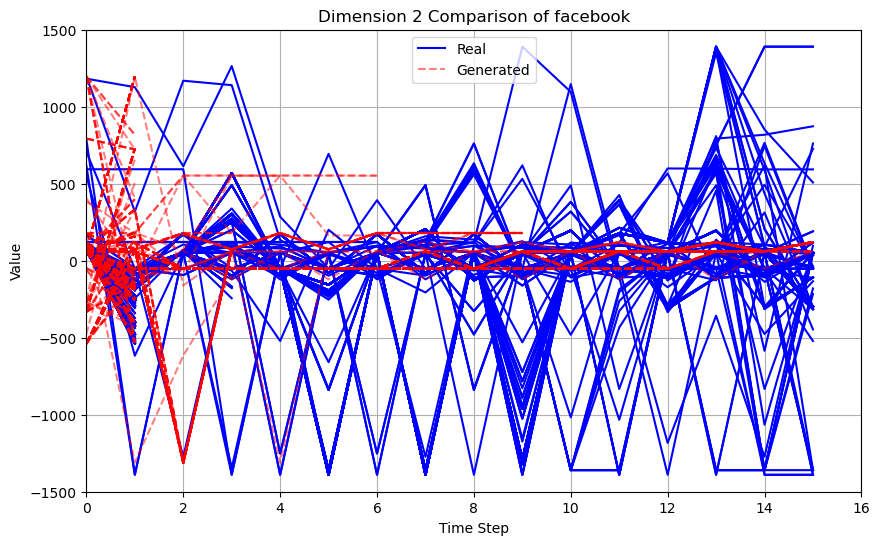

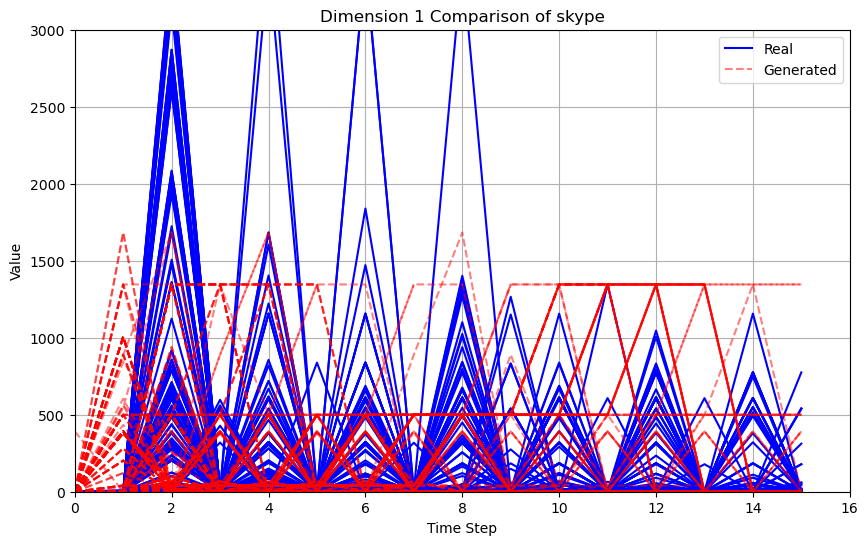

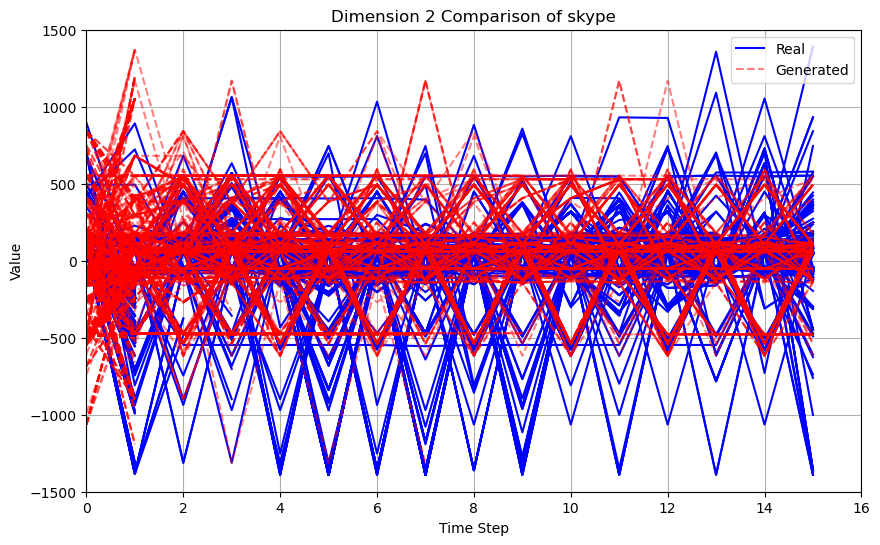

In [50]:
for label in LABEL_DICT.keys():
    real_data = real_datas[label]
    fake_data = fake_datas[label]
    real_sequences = np.array([pad(seq, MAX_SEQ_LEN) for seq in real_data])         # Shape: (num_samples, seq_len, num_dims)
    generated_sequences = np.array([pad(seq, MAX_SEQ_LEN) for seq in fake_data]) 

    num_samples, seq_len, num_dims = real_sequences.shape

    for dim in range(num_dims - 1):
        
        percentiles = [10, 90]
        quantiles = np.nanpercentile(real_sequences[:,:,dim], percentiles, axis=0)
        
        plt.figure(figsize=(10, 6))
        
        if dim == 0:
            plt.axis([0, 16, 0, 3000])
        else:
            plt.axis([0, 16, -1500, 1500])

        # 绘制真实数据序列（统一颜色）
        for i in range(len(real_sequences)):
            plt.plot(real_sequences[i, :, dim], color='blue', alpha=1.0, label="Real" if i == 0 else "")  # 使用蓝色，透明度为 0.6
    
        # 绘制生成数据序列（统一颜色）
        for i in range(len(generated_sequences)):
            plt.plot(generated_sequences[i, :, dim], color='red', alpha=0.5, linestyle='--', label="Generated" if i == 0 else "")  # 使用红色，透明度为 0.6
            
        # for q in quantiles:
        #     plt.plot(q, color='green', linestyle='--', linewidth=2.5, label='Real Data Quantiles' if 'Real Data Quantiles' not in plt.gca().get_legend_handles_labels()[1] else "")
    
        plt.title(f"Dimension {dim + 1} Comparison of {label}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()
        